# MF_Timestamp_Service(with mflib)

## Timestamp Service Overview

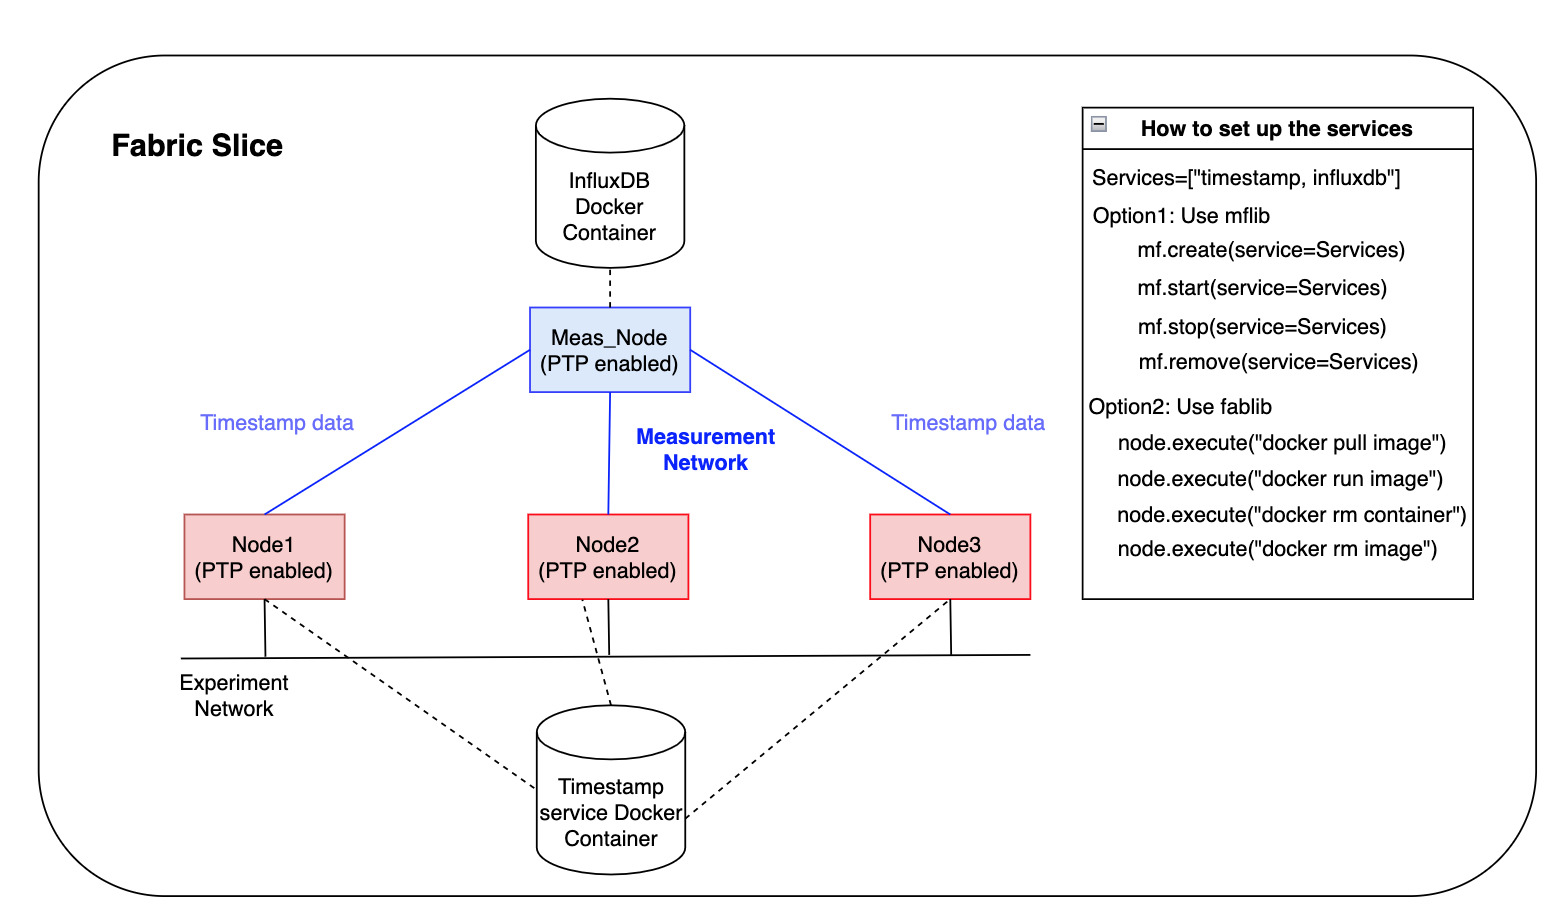

## Import

In [ ]:
import json
import os
import traceback
import importlib
import mflib 
print(f"MFLib version  {mflib.__version__} " )
from mflib.mflib import MFLib
from mflib.mf_timestamp import mf_timestamp 
#importlib.reload(mf_timestamp)
from fabrictestbed_extensions.fablib.fablib import fablib
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager

## Slice Info

In [ ]:
slice_name="L3mflib-timestamp"
container_name="timestamp"
node1_name = 'Node1'
node2_name = 'Node2'
node3_name = 'Node3'

In [ ]:
%%time
mf = MFLib(slice_name)

## Find the Measurement Node and Experiment Nodes

In [ ]:
meas_node_name = "_meas_node"
try:
    slice = fablib.get_slice(name=slice_name)
except Exception as e:
    print(f"Fail: {e}")
try:
    meas_node = slice.get_node(name=meas_node_name)
    node1 = slice.get_node(name=node1_name)
    node2 = slice.get_node(name=node2_name)
    node3 = slice.get_node(name=node3_name)
except Exception as e:
    print(f"Fail: {e}")

## Check whether PTP is running

In [ ]:
node1.execute("ps -ef | grep phc2sys")
node2.execute("ps -ef | grep phc2sys")
node3.execute("ps -ef | grep phc2sys")

## Setup timestamp service on nodes

### Pull the timestamp docker image to nodes and build the image

In [ ]:
%%time
mf.create(service="timestamp")

# Copies the timestamp Dockerfile from measurement node to each experiment node and builds the image

# Or alternatively pull the image from Fabric Docker Hub
# node1.execute("sudo docker pull fabrictestbed/timestamp:0.1.0")

### Run the timestamp docker image as a container on each experiment node

In [ ]:
# Runs the built image as Docker Container  
mf.start(services=["timestamp",])

# Or alternativly, 

#timestamp_bind_mount_volume = "/home/rocky/timestamp/"
#cmd = f'''
#      sudo docker run -dit \
#      -v {timestamp_bind_mount_volume}:/root/services/timestamp/output_files/ \
#      --pid=host --network=host --privileged \
#      --name timestamp fabrictestbed/timestamp:0.1.0
#      '''
#node1.execute(cmd)

### Check on each node if timestamp docker container is running

In [ ]:
command = f"sudo docker ps"
stdout, stderr= node1.execute(command)
stdout, stderr= node2.execute(command)
stdout, stderr= node3.execute(command)

## Create the object and set experiment name

In [ ]:
ts = mf_timestamp(slice_name=slice_name, container_name=container_name)
packet_test_name = "packet_test"
event_test_name= "event_test"

### Record timestamp for packets
#### This method will trigger tcpdump to record packets and write results to file

In [ ]:
# Need to Check the interface ens/eth on that node and pass as a parameter
# Prepare to run iperf from meas_node to this experiment node in the terminal 
# e.g, On node1: sudo iperf3 -s    On measurement node: sudo iperf -c {node1_IP_address} -t 15 -b 1G
ts.record_packet_timestamp(node=node1_name,name=packet_test_name, interface="eth1",ipversion="6",
                           protocol="tcp", duration="10", verbose=True)

### Get the recorded packet timestamp from local file

In [ ]:
packet_records= ts.get_packet_timestamp(node=node1_name, name=packet_test_name)

### Local Data Visualization using matplotlib 

In [ ]:
ts.plot_packet_timestamp(json_obj=packet_records)

### Record timestamp for events

In [ ]:
ts.record_event_timestamp(node=node1_name,name=event_test_name,event="'Ram usage above 80 percent'", verbose=True)

### Get the recorded event timestamp

In [ ]:
event_records=ts.get_event_timestamp(node=node1_name,name=event_test_name)

## Setup influxdb service on measurement node

In [ ]:
# Pulls the influxdb 2.0 docker image on measurement node
mf.create(service="influxdb")

# Or alternatively,
#meas_node.execute("sudo docker pull influxdb:2.0")

### Check influxdb image

In [ ]:
meas_node.execute("sudo docker image ls")

### Run influxdb in the docker container on measurement node

In [ ]:
# Runs the pulled image as a container
mf.start(services=["influxdb",])

# Or alternatively,
#influxdb_bind_mount_volume="/home/mfuser/influxdb"
#cmd = f'''
#      sudo docker run --privileged -d -p 8086:8086 \
#      -v {influxdb_bind_mount_volume}:/var/lib/influxdb2 \
#      -e DOCKER_INFLUXDB_INIT_MODE=setup \
#      -e DOCKER_INFLUXDB_INIT_USERNAME=my-user \
#      -e DOCKER_INFLUXDB_INIT_PASSWORD=my-password \
#      -e DOCKER_INFLUXDB_INIT_ORG=my-org \
#      -e DOCKER_INFLUXDB_INIT_BUCKET=my-bucket \
#      --network=host --privileged \
#      --name influxdb influxdb:2.0
#      '''
# meas_node.execute(cmd)

### Check influxdb docker container on measurement node 

In [ ]:
command = f"sudo docker ps"
stdout, stderr= meas_node.execute(command)

## Get influxdb info from the measurement node

### Open InfluxDB port

In [ ]:
command = f"sudo ufw allow 8086"
stdout, stderr= meas_node.execute(command)

### List influxdb info

In [ ]:
print ("List buckets")
command = f"sudo docker exec influxdb influx bucket list -o my-org"
stdout, stderr= meas_node.execute(command)

print ("\nList orgs")
command = f"sudo docker exec influxdb influx org list --json"
stdout, stderr= meas_node.execute(command)
org_id = str(json.loads(stdout)[0]["id"])

print ("\nList tokens")
command = f"sudo docker exec influxdb influx auth list --json"
stdout, stderr= meas_node.execute(command)

## Upload data to influxdb

### Get influx info

In [ ]:
token = str(json.loads(stdout)[0]["token"])
bucket = "my-bucket"
org="my-org"  

### Upload packet and event data to influxdb

In [ ]:
ts.upload_influx(node=node1_name, data_type="packet_data", bucket=bucket, org=org, token=token)

In [ ]:
ts.upload_influx(node=node1_name, data_type="event_data", bucket=bucket, org=org, token=token)

## Download from influxdb

### Download packet and event data from influx db

In [ ]:
ts.download_influx(node=node1_name, data_type="packet_data", bucket=bucket, org=org, token=token, name=packet_test_name)

In [ ]:
ts.download_influx(node=node1_name, data_type="event_data", bucket=bucket, org=org, token=token, name=event_test_name)

## Visualize the influxdb web UI

In [ ]:
# Set up ssh tunneling and provide the local port number
# ssh -L 9999:localhost:8086 -F ~/.ssh/fabric_ssh_config \
#     -i ~/.ssh/fabric_slice_key ubuntu@meas_node_ip 
port="9999"
URL=f"http://localhost:{port}/orgs/{org_id}/data-explorer?bucket={bucket}"
print (URL)

In [ ]:
from IPython.display import IFrame
IFrame(URL, width=1200, height=800)

### Upload a custom dashboard

In [ ]:
# Use mf_timestamp
cwd = os.getcwd()
dashboard_file_relative_path = "/dashboard_examples/influxdb/influxdb_timestamp_dashboard.yml"
dashboard_file_real_path = os.path.join(cwd, dashboard_relative_path)
ts.deploy_influxdb_dashboard(dashboard_file=dashboard_file_real_path)

# Or
# Upload the dashboard file to the directory on meas_node that binds mount on influxdb container
#meas_node.upload_file(local_file_path=dashboard_file_real_path, remote_file_path="/home/mfuser/influxdb/dashboard.yml")

# Apply the template in influxdb 
#command = f"sudo docker exec -i influxdb influx apply --skip-verify --file /var/lib/influxdb2/dashboard.yml"
#stdout, stderr= meas_node.execute(command)

## Stop the services 

In [ ]:
# Use mflib to stop the timestamp container
mf.stop(services=["timestamp",])

# Or alternatively,
#stdout=node1.execute("sudo docker ps -aqf 'name=timestamp'", quiet=True)
#timestamp_container_id=stdout[0]
#stdout,stderr= node1.execute(f"sudo docker container stop {timestamp_container_id}", quiet=True)

In [ ]:
# Use mflib to stop the influxdb container
mf.stop(services=["influxdb",])

# Or alternatively,
#stdout=meas_node.execute("sudo docker ps -aqf 'name=influxdb'", quiet=True)
#influxdb_container_id=stdout[0]
#stdout,stderr= meas_node.execute(f"sudo docker container stop {influxdb_container_id}", quiet=True)


## Remove the services

In [ ]:
# Use mflib to stop the timestamp container
mf.remove(services=["timestamp",])

# Or alternatively,
#stdout,stderr= node3.execute(f"sudo docker rm -v timestamp", quiet=True)

# Remove the timestamp docker image
#stdout,stderr= node3.execute("sudo docker rmi -f fabrictestbed/timestamp:0.1.0")

# Remove the bind mount volume
#stdout,stderr= node3.execute(f"sudo rm -rf {timestamp_bind_mount_volume}")

In [ ]:
# Use mflib to stop the influxdb container
mf.remove(services=["influxdb",])

# Or alternatively,
#stdout,stderr= meas_node.execute(f"sudo docker rm -v influxdb", quiet=True)

# Remove the influxdb docker image
#stdout,stderr= meas_node.execute("sudo docker rmi -f influxdb:2.0")

# Remove the bind mount volume
#stdout,stderr= meas_node.execute(f"sudo rm -rf {influxdb_bind_mount_volume}")

In [ ]:
for node in [node1, node2, node3]:
    stdout,stderr= node.execute("sudo docker ps -a")
    stdout,stderr= node.execute("sudo docker image ls")

In [ ]:
stdout,stderr= meas_node.execute("sudo docker ps -a")
stdout,stderr= meas_node.execute("sudo docker image ls")